# Notebook - Fractopo – KB7 Trace Data Validation

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import geopandas as gpd

In [3]:
# This cell's contents only for development purposes.
from importlib.util import find_spec

if find_spec("fractopo") is None:
    import sys

    sys.path.append("../../")

In [4]:
from fractopo import Validation
import matplotlib.pyplot as plt

plt.close()

## Data (KB7)

In [5]:
# Trace and target area data available on GitHub
trace_data_url = "https://raw.githubusercontent.com/nialov/fractopo/master/tests/sample_data/KB7/KB7_traces.geojson"
area_data_url = "https://raw.githubusercontent.com/nialov/fractopo/master/tests/sample_data/KB7/KB7_area.geojson"

# Use geopandas to load data from urls
traces = gpd.read_file(trace_data_url)
area = gpd.read_file(area_data_url)

# Name the dataset
name = "KB7"

## Validation (KB7)

In [6]:
# Create validation object with fixing (i.e. modification of data) allowed.
# AREA_EDGE_SNAP_MULTIPLIER is overridden to keep catching this error even with future default
# value changes
kb7_validation = Validation(
    traces, area, name=name, allow_fix=True, AREA_EDGE_SNAP_MULTIPLIER=2.5
)

In [7]:
# Run actual validation and capture the outputted validated trace GeoDataFrame
kb7_validated = kb7_validation.run_validation()

## Validation results (KB7)

In [8]:
# Normal DataFrame methods are available for data inspection
kb7_validated.columns

Index(['Name', 'Shape_Leng', 'geometry', 'VALIDATION_ERRORS'], dtype='object')

In [9]:
# Convert column data to string to allow hashing and return all unique
# validation errors.
kb7_validated["VALIDATION_ERRORS"].astype(str).unique()

array(['[]', "['MULTI JUNCTION']", "['SHARP TURNS']",
       "['TRACE UNDERLAPS TARGET AREA']"], dtype=object)

In [10]:
# Better description function is found in fractopo.cli
from fractopo.cli import describe_results

describe_results(kb7_validated, kb7_validation.ERROR_COLUMN)

Out of 240 traces, 7 were invalid.

There were 3 error types. These were:
SHARP TURNS
TRACE UNDERLAPS TARGET AREA
MULTI JUNCTION

The KB7 dataset contains the above errors of which `MULTI JUNCTION` and `TRACE UNDERLAPS TARGET AREA` are disruptive in further analysis.

See documentation: https://fractopo.readthedocs.io/en/latest/validation/errors.html

## Visualization of errors in notebook

Though visualization here is possible, GIS-software (e.g. QGIS, ArcGIS) are much more interactive and are recommended for actual fixing and further error inspection.

### MULTI JUNCTION

In [11]:
# Find MULTI JUNCTION erroneous traces in GeoDataFrame
kb7_multijunctions = kb7_validated.loc[
    ["MULTI JUNCTION" in err for err in kb7_validated[kb7_validation.ERROR_COLUMN]]
]
kb7_multijunctions

,Name,Shape_Leng,geometry,VALIDATION_ERRORS
168,None,4.985900,"LINESTRING (466023.424 6692098.176, 466024.252...",[MULTI JUNCTION]
169,None,5.232445,"LINESTRING (466025.131 6692096.856, 466026.650...",[MULTI JUNCTION]
171,None,1.541532,"LINESTRING (466024.020 6692098.386, 466023.703...",[MULTI JUNCTION]
206,None,1.864415,"LINESTRING (466025.700 6692097.183, 466025.858...",[MULTI JUNCTION]
219,None,0.619474,"LINESTRING (466023.571 6692097.978, 466023.802...",[MULTI JUNCTION]


<AxesSubplot:>

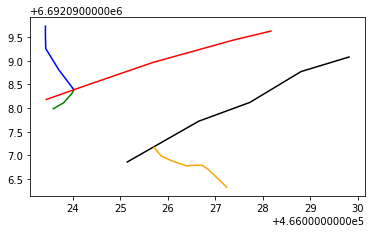

In [12]:
kb7_multijunctions.plot(colors=["red", "black", "blue", "orange", "green"])

The plot shows that the green and blue traces abut at their endpoints
which is not a valid topology for traces.
The fix is done by merging the green and blue traces.

Additionally the orange trace has a dangling end instead of being accurately snapped to the black trace. 

<AxesSubplot:>

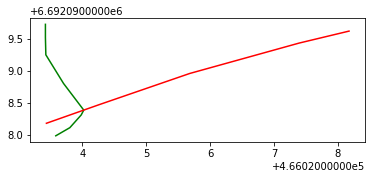

In [13]:
# Example fix for blue and green traces
from shapely.ops import linemerge

gpd.GeoSeries(
    [
        linemerge(
            [kb7_multijunctions.geometry.iloc[4], kb7_multijunctions.geometry.iloc[2]]
        ),
        kb7_multijunctions.geometry.iloc[0],
    ]
).plot(colors=["green", "red"])

### TRACE UNDERLAPS TARGET AREA

In [14]:
# Find TRACE UNDERLAPS TARGET AREA erroneous traces in GeoDataFrame
kb7_underlaps = kb7_validated.loc[
    [
        "TRACE UNDERLAPS TARGET AREA" in err
        for err in kb7_validated[kb7_validation.ERROR_COLUMN]
    ]
]
kb7_underlaps

,Name,Shape_Leng,geometry,VALIDATION_ERRORS
207,None,0.679687,"LINESTRING (466025.246 6692096.378, 466025.377...",[TRACE UNDERLAPS TARGET AREA]


(6692095.263678445, 6692096.877513003)

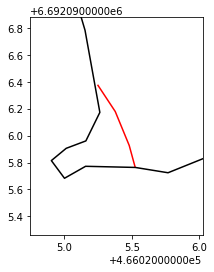

In [15]:
# Create figure, ax base
fig, ax = plt.subplots()

# Plot the underlapping trace along with the trace area boundary
kb7_underlaps.plot(ax=ax, color="red")
area.boundary.plot(ax=ax, color="black")

# Get trace bounds
minx, miny, maxx, maxy = kb7_underlaps.total_bounds

ax.set_xlim(minx - 0.5, maxx + 0.5)
ax.set_ylim(miny - 0.5, maxy + 0.5)

The plot shows that the trace underlaps the target area at least on the northern end and maybe on the southern end. The fix is implemented by extending the trace to meet the target area boundary.